In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sys
from copy import deepcopy



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:

NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [4]:
# Load CIFAR-10
def load_cifar10(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
    return trainloader, testloader

# Load data
BATCH_SIZE = 128
print("\n..... Loading CIFAR-10 dataset...")
train_loader, test_loader = load_cifar10(BATCH_SIZE)
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


..... Loading CIFAR-10 dataset...


Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000
Test samples: 10000


In [5]:
# ======== Basic Residual Block (used in ResNet-18/34) ======== #
class BasicBlock(nn.Module):
    expansion = 1  # output channels = in_channels * expansion

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out


# ======== Bottleneck Block (used in ResNet-50/101/152) ======== #
class Bottleneck(nn.Module):
    expansion = 4  # output channels = out_channels * 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)
        return out


# ======== ResNet Architecture ======== #
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        self.in_channels = 64

        # Initial convolution + maxpool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x, mode=None,pp=False,c=(0,0,0,0)):
    #def forward(self, x, mode=None):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# ======== Factory functions ======== #
def ResNet18(num_classes=1000):
    """Constructs a ResNet-18 model."""
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


def ResNet50(num_classes=1000):
    """Constructs a ResNet-50 model."""
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)



In [6]:
def train_model(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        pbar.set_postfix({
            'loss': running_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [7]:
def evaluate_model(model, test_loader, criterion, mode=None,c=None):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            output = model(data, mode=mode,c=c)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc

In [8]:
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss plot
    ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
    ax1.plot(history['test_loss'], label='Test Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    ax2.plot(history['test_acc'], label='Test Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    print(f'Saved training history plot: {model_name}_training_history.png')
    plt.show()

In [9]:
def initial_training(model_name, num_classes=10):
    if model_name == 'ResNet18':
        model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    elif model_name == 'ResNet50':
        model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)
    print(f"....... Training {model_name}")

    # Initialize model
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    # Training loop
    print(f"\nTraining {model_name} for {NUM_EPOCHS} epochs...")
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_acc = train_model(model, train_loader, criterion, 
                                            optimizer, epoch)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion)
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        print(f'\nEpoch {epoch}/{NUM_EPOCHS}:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%')

    # Final evaluation
    print(f"\n...... Final Evaluation for {model_name}...")
    final_test_loss, final_test_acc = evaluate_model(model, test_loader, criterion)
    print(f"{model_name} - FINAL RESULTS")
    print(f"{'=' * 60}")
    print(f"Final Test Loss: {final_test_loss:.4f}")
    print(f"Final Test Accuracy: {final_test_acc:.2f}%")

    # Save model
    print(f"\n..... Saving {model_name} model...")
    torch.save({
        'epoch': NUM_EPOCHS,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'test_loss': final_test_loss,
        'test_acc': final_test_acc,
        'history': history
    }, f'{model_name}_cifar10.pth')
    print(f"Model saved as: {model_name}_cifar10.pth")

    # Plot training history
    print(f"\n....... Plotting training history for {model_name}...")
    plot_history(history, model_name)

....... Training ResNet50

Training ResNet50 for 10 epochs...


Evaluating: 100%|██████████| 79/79 [00:18<00:00,  4.28it/s]



Epoch 1/10:
  Train Loss: 1.7530 | Train Acc: 39.59%
  Test Loss:  1.4665 | Test Acc:  47.80%


Evaluating: 100%|██████████| 79/79 [00:18<00:00,  4.29it/s]



Epoch 2/10:
  Train Loss: 1.4275 | Train Acc: 50.79%
  Test Loss:  1.2660 | Test Acc:  55.88%


Evaluating: 100%|██████████| 79/79 [00:19<00:00,  4.12it/s]



Epoch 3/10:
  Train Loss: 1.6352 | Train Acc: 45.23%
  Test Loss:  6.1701 | Test Acc:  30.23%


Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.52it/s]



Epoch 4/10:
  Train Loss: 1.5705 | Train Acc: 45.83%
  Test Loss:  1.3481 | Test Acc:  52.99%


Evaluating: 100%|██████████| 79/79 [00:18<00:00,  4.20it/s]



Epoch 5/10:
  Train Loss: 1.3077 | Train Acc: 55.91%
  Test Loss:  1.3840 | Test Acc:  53.60%


Evaluating: 100%|██████████| 79/79 [00:31<00:00,  2.54it/s]



Epoch 6/10:
  Train Loss: 1.0357 | Train Acc: 63.26%
  Test Loss:  1.0467 | Test Acc:  62.90%


Evaluating: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]



Epoch 7/10:
  Train Loss: 0.9194 | Train Acc: 67.34%
  Test Loss:  1.0068 | Test Acc:  64.30%


Evaluating: 100%|██████████| 79/79 [00:31<00:00,  2.54it/s]



Epoch 8/10:
  Train Loss: 0.8399 | Train Acc: 70.24%
  Test Loss:  0.9989 | Test Acc:  65.18%


Evaluating: 100%|██████████| 79/79 [00:30<00:00,  2.57it/s]



Epoch 9/10:
  Train Loss: 0.7611 | Train Acc: 73.05%
  Test Loss:  0.9791 | Test Acc:  65.73%


Evaluating: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]



Epoch 10/10:
  Train Loss: 0.6723 | Train Acc: 76.46%
  Test Loss:  0.9975 | Test Acc:  66.05%

...... Final Evaluation for ResNet50...


Evaluating: 100%|██████████| 79/79 [00:30<00:00,  2.55it/s]


ResNet50 - FINAL RESULTS
Final Test Loss: 0.9975
Final Test Accuracy: 66.05%

..... Saving ResNet50 model...
Model saved as: ResNet50_cifar10.pth

....... Plotting training history for ResNet50...
Saved training history plot: ResNet50_training_history.png


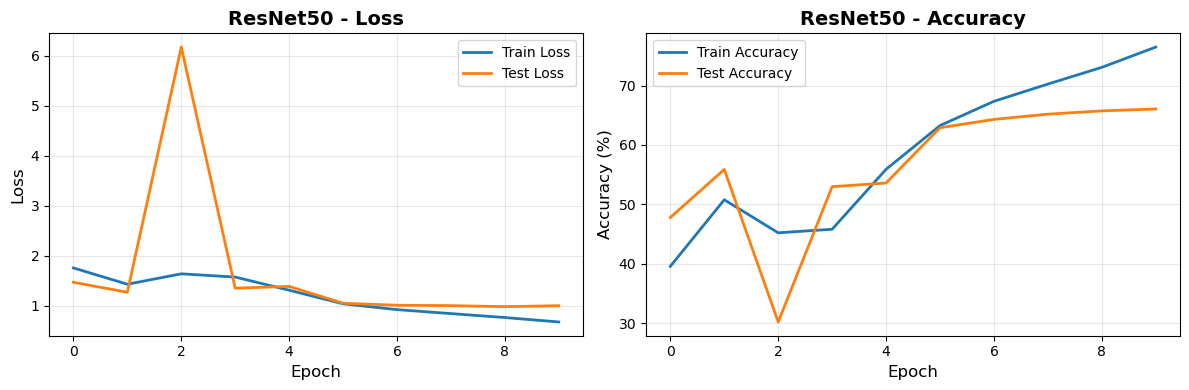

In [10]:
model_name = "ResNet50" # valid values: ResNet18, ResNet50
initial_training(model_name)

